In [23]:
%load_ext nb_black


The nb_black extension is already loaded. To reload it, use:
  %reload_ext nb_black


<IPython.core.display.Javascript object>

In [24]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tensorflow as tf
import sklearn.preprocessing
import numpy as np
import numpy as np
import random

random.seed(42)

from sklearn.metrics import accuracy_score, precision_score, recall_score
from sklearn.model_selection import train_test_split
from tensorflow.keras import layers, losses
from tensorflow.keras.datasets import fashion_mnist
from tensorflow.keras.models import Model


## load the libraries
from keras.layers import Dense, Input, Conv2D, LSTM, MaxPool2D, UpSampling2D
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from tensorflow.keras.utils import to_categorical
from numpy import argmax, array_equal
import matplotlib.pyplot as plt
from keras.models import Model
from imgaug import augmenters
from random import randint
import pandas as pd
import numpy as np

<IPython.core.display.Javascript object>

In [25]:


# vocabularies:
DNA = ["A", "C", "G", "T"]
RNA = ["A", "C", "G", "U"]
AMINO_ACIDS = ["A", "R", "N", "D", "B", "C", "E", "Q", "Z", "G", "H",
               "I", "L", "K", "M", "F", "P", "S", "T", "W", "Y", "V"]
CODONS = ["AAA", "AAC", "AAG", "AAT", "ACA", "ACC", "ACG", "ACT", "AGA",
          "AGC", "AGG", "AGT", "ATA", "ATC", "ATG", "ATT", "CAA", "CAC",
          "CAG", "CAT", "CCA", "CCC", "CCG", "CCT", "CGA", "CGC", "CGG",
          "CGT", "CTA", "CTC", "CTG", "CTT", "GAA", "GAC", "GAG", "GAT",
          "GCA", "GCC", "GCG", "GCT", "GGA", "GGC", "GGG", "GGT", "GTA",
          "GTC", "GTG", "GTT", "TAC", "TAT", "TCA", "TCC", "TCG", "TCT",
          "TGC", "TGG", "TGT", "TTA", "TTC", "TTG", "TTT"]
STOP_CODONS = ["TAG", "TAA", "TGA"]


def _get_vocab_dict(vocab):
    return {l: i for i, l in enumerate(vocab)}


def _get_index_dict(vocab):
    return {i: l for i, l in enumerate(vocab)}


def one_hot2token(arr):
    return arr.argmax(axis=2)


# TODO - take into account the neutral vocab
def one_hot2string(arr, vocab):
    """Convert a one-hot encoded array back to string
    """
    tokens = one_hot2token(arr)
    indexToLetter = _get_index_dict(vocab)

    return [''.join([indexToLetter[x] for x in row]) for row in tokens]


def tokenize(seq, vocab, neutral_vocab=[]):
    """Convert sequence to integers

    # Arguments
       seq: Sequence to encode
       vocab: Vocabulary to use
       neutral_vocab: Neutral vocabulary -> assign those values to -1

    # Returns
       List of length `len(seq)` with integers from `-1` to `len(vocab) - 1`
    """
    # Req: all vocabs have the same length
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]

    nchar = len(vocab[0])
    for l in vocab + neutral_vocab:
        assert len(l) == nchar
    assert len(seq) % nchar == 0  # since we are using striding

    vocab_dict = _get_vocab_dict(vocab)
    for l in neutral_vocab:
        vocab_dict[l] = -1

    # current performance bottleneck
    return [vocab_dict[seq[(i * nchar):((i + 1) * nchar)]] for i in range(len(seq) // nchar)]


# 512 ms vs 121 -> 4x slower than custom token2one_hot
# def token2one_hot(tvec, vocab_size):
#     """
#     Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
#     """
#     # This costs the most - memory allocation?
#     lb = sklearn.preprocessing.LabelBinarizer()
#     lb.fit(range(vocab_size))
#     return lb.transform(tvec)
#     # alternatively:
#     # return sklearn.preprocessing.label_binarize(tvec, list(range(vocab_size)))


def token2one_hot(tvec, vocab_size):
    """
    Note: everything out of the vucabulary is transformed into `np.zeros(vocab_size)`
    """
    arr = np.zeros((len(tvec), vocab_size))

    tvec_range = np.arange(len(tvec))
    tvec = np.asarray(tvec)
    arr[tvec_range[tvec >= 0], tvec[tvec >= 0]] = 1
    return arr


def encodeSequence(seq_vec, vocab, neutral_vocab, maxlen=None,
                   seq_align="start", pad_value="N", encode_type="one_hot"):
    """Convert a list of genetic sequences into one-hot-encoded array.

    # Arguments
       seq_vec: list of strings (genetic sequences)
       vocab: list of chars: List of "words" to use as the vocabulary. Can be strings of length>0,
            but all need to have the same length. For DNA, this is: ["A", "C", "G", "T"].
       neutral_vocab: list of chars: Values used to pad the sequence or represent unknown-values. For DNA, this is: ["N"].
       maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.
       seq_align: character; 'end' or 'start'
            To which end should we align sequences?
       encode_type: "one_hot" or "token". "token" represents each vocab element as a positive integer from 1 to len(vocab) + 1.
                  neutral_vocab is represented with 0.

    # Returns
        Array with shape for encode_type:

            - "one_hot": `(len(seq_vec), maxlen, len(vocab))`
            - "token": `(len(seq_vec), maxlen)`

        If `maxlen=None`, it gets the value of the longest sequence length from `seq_vec`.
    """
    if isinstance(neutral_vocab, str):
        neutral_vocab = [neutral_vocab]
    if isinstance(seq_vec, str):
        raise ValueError("seq_vec should be an iterable returning " +
                         "strings not a string itself")
    assert len(vocab[0]) == len(pad_value)
    assert pad_value in neutral_vocab

    assert encode_type in ["one_hot", "token"]

    seq_vec = pad_sequences(seq_vec, maxlen=maxlen,
                            align=seq_align, value=pad_value)

    if encode_type == "one_hot":
        arr_list = [token2one_hot(tokenize(seq, vocab, neutral_vocab), len(vocab))
                    for i, seq in enumerate(seq_vec)]
    elif encode_type == "token":
        arr_list = [1 + np.array(tokenize(seq, vocab, neutral_vocab)) for seq in seq_vec]
        # we add 1 to be compatible with keras: https://keras.io/layers/embeddings/
        # indexes > 0, 0 = padding element

    return np.stack(arr_list)


def encodeDNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the DNA sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: list of chars
            List of sequences that can have different lengths

        maxlen: int or None,
            Should we trim (subset) the resulting sequence. If None don't trim.
            Note that trims wrt the align parameter.
            It should be smaller than the longest sequence.

        seq_align: character; 'end' or 'start'
            To which end should we align sequences?

    # Returns
        3D numpy array of shape (len(seq_vec), trim_seq_len(or maximal sequence length if None), 4)

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> X_seq = encodeDNA(sequence_vec, seq_align="end", maxlen=8)
            >>> X_seq.shape
            (2, 8, 4)

            >>> print(X_seq)
            [[[0 0 0 1]
              [1 0 0 0]
              [0 1 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [1 0 0 0]
              [0 0 1 0]
              [1 0 0 0]]

             [[0 0 0 0]
              [0 0 0 0]
              [0 0 0 1]
              [0 1 0 0]
              [0 0 0 1]
              [0 0 0 1]
              [0 0 0 1]
              [1 0 0 0]]]
        ```
    """
    return encodeSequence(seq_vec,
                          vocab=DNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeRNA(seq_vec, maxlen=None, seq_align="start"):
    """Convert the RNA sequence into 1-hot-encoding numpy array as for encodeDNA
    """
    return encodeSequence(seq_vec,
                          vocab=RNA,
                          neutral_vocab="N",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="N",
                          encode_type="one_hot")


def encodeCodon(seq_vec, ignore_stop_codons=True, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Codon sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/DNA sequences
        ignore_stop_codons: boolean; if True, STOP_CODONS are omitted from one-hot encoding.
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen / 3, 61 if ignore_stop_codons else 64)`
    """
    if ignore_stop_codons:
        vocab = CODONS
        neutral_vocab = STOP_CODONS + ["NNN"]
    else:
        vocab = CODONS + STOP_CODONS
        neutral_vocab = ["NNN"]

    # replace all U's with A's?
    seq_vec = [str(seq).replace("U", "T") for seq in seq_vec]

    return encodeSequence(seq_vec,
                          vocab=vocab,
                          neutral_vocab=neutral_vocab,
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="NNN",
                          encode_type=encode_type)


def encodeAA(seq_vec, maxlen=None, seq_align="start", encode_type="one_hot"):
    """Convert the Amino-acid sequence into 1-hot-encoding numpy array

    # Arguments
        seq_vec: List of strings/amino-acid sequences
        maxlen: Maximum sequence length. See `pad_sequences` for more detail
        seq_align: How to align the sequences of variable lengths. See `pad_sequences` for more detail
        encode_type: can be `"one_hot"` or `token` for token encoding of codons (incremental integer ).

    # Returns
        numpy.ndarray of shape `(len(seq_vec), maxlen, 22)`
    """
    return encodeSequence(seq_vec,
                          vocab=AMINO_ACIDS,
                          neutral_vocab="_",
                          maxlen=maxlen,
                          seq_align=seq_align,
                          pad_value="_",
                          encode_type=encode_type)


def pad_sequences(sequence_vec, maxlen=None, align="end", value="N"):
    """Pad and/or trim a list of sequences to have common length. Procedure:

        1. Pad the sequence with N's or any other string or list element (`value`)
        2. Subset the sequence

    # Note
        See also: https://keras.io/preprocessing/sequence/
        Aplicable also for lists of characters

    # Arguments
        sequence_vec: list of chars or lists
            List of sequences that can have various lengths
        value: Neutral element to pad the sequence with. Can be `str` or `list`.
        maxlen: int or None; Final lenght of sequences.
             If None, maxlen is set to the longest sequence length.
        align: character; 'start', 'end' or 'center'
            To which end to align the sequences when triming/padding. See examples bellow.

    # Returns
        List of sequences of the same class as sequence_vec

    # Example

        ```python
            >>> sequence_vec = ['CTTACTCAGA', 'TCTTTA']
            >>> pad_sequences(sequence_vec, 10, align="start", value="N")
            ['CTTACTCAGA', 'TCTTTANNNN']
            >>> pad_sequences(sequence_vec, 10, align="end", value="N")
            ['CTTACTCAGA', 'NNNNTCTTTA']
            >>> pad_sequences(sequence_vec, 4, align="center", value="N")
            ['ACTC', 'CTTT']
        ```
    """

    # neutral element type checking
    assert isinstance(value, list) or isinstance(value, str)
    assert isinstance(value, type(sequence_vec[0]))
    assert not isinstance(sequence_vec, str)
    assert isinstance(sequence_vec[0], list) or isinstance(sequence_vec[0], str)

    max_seq_len = max([len(seq) for seq in sequence_vec])

    if maxlen is None:
        maxlen = max_seq_len
    else:
        maxlen = int(maxlen)

    if max_seq_len < maxlen:
        import warnings
        warnings.warn("Maximum sequence length (%s) is less than maxlen (%s)" % (max_seq_len, maxlen))
        max_seq_len = maxlen

    # check the case when len > 1
    for seq in sequence_vec:
        if not len(seq) % len(value) == 0:
            raise ValueError("All sequences need to be dividable by len(value)")
    if not maxlen % len(value) == 0:
        raise ValueError("maxlen needs to be dividable by len(value)")

    # pad and subset
    def pad(seq, max_seq_len, value="N", align="end"):
        seq_len = len(seq)
        assert max_seq_len >= seq_len
        if align == "end":
            n_left = max_seq_len - seq_len
            n_right = 0
        elif align == "start":
            n_right = max_seq_len - seq_len
            n_left = 0
        elif align == "center":
            n_left = (max_seq_len - seq_len) // 2 + (max_seq_len - seq_len) % 2
            n_right = (max_seq_len - seq_len) // 2
        else:
            raise ValueError("align can be of: end, start or center")

        # normalize for the length
        n_left = n_left // len(value)
        n_right = n_right // len(value)

        return value * n_left + seq + value * n_right

    def trim(seq, maxlen, align="end"):
        seq_len = len(seq)

        assert maxlen <= seq_len
        if align == "end":
            return seq[-maxlen:]
        elif align == "start":
            return seq[0:maxlen]
        elif align == "center":
            dl = seq_len - maxlen
            n_left = dl // 2 + dl % 2
            n_right = seq_len - dl // 2
            return seq[n_left:n_right]
        else:
            raise ValueError("align can be of: end, start or center")

    padded_sequence_vec = [pad(seq, max(max_seq_len, maxlen),
                               value=value, align=align) for seq in sequence_vec]
    padded_sequence_vec = [trim(seq, maxlen, align=align) for seq in padded_sequence_vec]

    return padded_sequence_vec


<IPython.core.display.Javascript object>

In [26]:
def random_dna_sequence(length):
    return "".join(random.choice("ACTG") for _ in range(length))


samples = 100000
features = 51
inp_size = 25
out_size = 3

data = []
for _ in range(samples):
    dna = random_dna_sequence(inp_size)
    data.append(dna)
#     print(dna, base_frequency(dna))

<IPython.core.display.Javascript object>

In [27]:
X_seq = encodeDNA(data, seq_align="end", maxlen=inp_size)

<IPython.core.display.Javascript object>

In [28]:
X_seq.shape

(100000, 25, 4)

<IPython.core.display.Javascript object>

In [29]:
data[0]

'AATCCCAAGAAACCACGCGTACGTT'

<IPython.core.display.Javascript object>

In [30]:
X_seq[0]

array([[1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 0., 1.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 0., 1., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 1., 0., 0.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       [0., 1., 0., 0.],
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 0., 1.]])

<IPython.core.display.Javascript object>

In [31]:
def define_models(n_input, n_output):
    ## define the encoder architecture
    ## input : sequence
    ## output : encoder states
    encoder_inputs = Input(shape=(None, n_input))
    encoder = LSTM(128, return_state=True)
    encoder_outputs, state_h, state_c = encoder(encoder_inputs)
    encoder_states = [state_h, state_c]

    ## define the encoder-decoder architecture
    ## input : a seed sequence
    ## output : decoder states, decoded output
    decoder_inputs = Input(shape=(None, n_output))
    decoder_lstm = LSTM(128, return_sequences=True, return_state=True)
    decoder_outputs, _, _ = decoder_lstm(decoder_inputs, initial_state=encoder_states)
    decoder_dense = Dense(n_output, activation="softmax")
    decoder_outputs = decoder_dense(decoder_outputs)
    model = Model([encoder_inputs, decoder_inputs], decoder_outputs)

    ## define the decoder model
    ## input : current states + encoded sequence
    ## output : decoded sequence
    encoder_model = Model(encoder_inputs, encoder_states)
    decoder_state_input_h = Input(shape=(128,))
    decoder_state_input_c = Input(shape=(128,))
    decoder_states_inputs = [decoder_state_input_h, decoder_state_input_c]
    decoder_outputs, state_h, state_c = decoder_lstm(
        decoder_inputs, initial_state=decoder_states_inputs
    )
    decoder_states = [state_h, state_c]
    decoder_outputs = decoder_dense(decoder_outputs)
    decoder_model = Model(
        [decoder_inputs] + decoder_states_inputs, [decoder_outputs] + decoder_states
    )

    return model, encoder_model, decoder_model

<IPython.core.display.Javascript object>

In [32]:
autoencoder, encoder_model, decoder_model = define_models(features, features)

<IPython.core.display.Javascript object>

In [33]:
encoder_model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, None, 51)]        0         
                                                                 
 lstm (LSTM)                 [(None, 128),             92160     
                              (None, 128),                       
                              (None, 128)]                       
                                                                 
Total params: 92,160
Trainable params: 92,160
Non-trainable params: 0
_________________________________________________________________


<IPython.core.display.Javascript object>

In [34]:
decoder_model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, None, 51)]   0           []                               
                                                                                                  
 input_3 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 input_4 (InputLayer)           [(None, 128)]        0           []                               
                                                                                                  
 lstm_1 (LSTM)                  [(None, None, 128),  92160       ['input_2[0][0]',                
                                 (None, 128),                     'input_3[0][0]',          

<IPython.core.display.Javascript object>

In [35]:
autoencoder.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, None, 51)]   0           []                               
                                                                                                  
 input_2 (InputLayer)           [(None, None, 51)]   0           []                               
                                                                                                  
 lstm (LSTM)                    [(None, 128),        92160       ['input_1[0][0]']                
                                 (None, 128),                                                     
                                 (None, 128)]                                                     
                                                                                              

<IPython.core.display.Javascript object>

In [47]:
autoencoder.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["acc"])
autoencoder.fit([X_seq, X_seq2], X_seq2, epochs=10)

Epoch 1/10


ValueError: in user code:

    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model" is incompatible with the layer: expected shape=(None, None, 51), found shape=(32, 25, 4)


<IPython.core.display.Javascript object>

In [38]:
X_seq

array([[[1., 0., 0., 0.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 0., 1.]],

       [[0., 1., 0., 0.],
        [0., 1., 0., 0.],
        [0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0.],
        [0., 1., 0., 0.],
        [1., 0., 0., 0.]],

       [[0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 1., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]],

       ...,

       [[0., 1., 0., 0.],
        [0., 0., 0., 1.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0., 0., 1.],
        [1., 0., 0., 0.]],

       [[0., 0., 0., 1.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [0., 0., 0., 1.],
        [1., 0., 0., 0.],
        [0., 0., 0., 1.]],

       [[0., 0., 1., 0.],
        [0., 0., 1., 0.],
        [0., 0., 1., 0.],
        ...,
        [1., 0., 0., 0.],
        [0., 0.

<IPython.core.display.Javascript object>

In [39]:
data

['AATCCCAAGAAACCACGCGTACGTT',
 'CCTAAGATTTAGAGATTCAACTACA',
 'GTGTCTTCTACCCGGTCTACATGTA',
 'CTCGGGCTCCTGGTCCGAAACCGAG',
 'GGTAATTATGCGATCATCCTCATGA',
 'ATTCACAAGACCGCTGCCTGTGGAC',
 'CATACCAAACAATACTGCCGCGGCA',
 'AGTGGGAAAGTACCCGCGCTGCAGA',
 'AAACCGGGCGACGAGTGTGGCCTCA',
 'ATAAGCAACAACGACAAGTTCTCTG',
 'CTGTAAGAACTCTACTTCGTATACT',
 'AACTTCTCTGTAAGTAATCTCGGAA',
 'ACATCGCATTATCCATGCCCCGACT',
 'GCTCAGAGCCGTTCCACGTTATTGT',
 'AATCTAAGTTGAGCTAGACTGATTA',
 'TTGTGTCCGGCTGATTCGTGGGCGC',
 'ATTACTCCCAACGAGGCGGGCCAAG',
 'CCGACAGCGTGGGCGGTCTGCTGAT',
 'CTTTACCCGCCAGGTGGACGGAGGA',
 'TTGGCGCTGGAGTGCGCAGAAGCGC',
 'ATGTCGTTGTGTAGAATCAAACCAC',
 'CCGACGTTCACTAATGGCACATAAT',
 'GTATAGGAGTGCGCTGGGTTCATGC',
 'GGTAGTCGCTTTTTACACGGCGGGA',
 'ATCGCTTGTGTTGTTTCACTACCCG',
 'TTACTCTCTACTAATCGAATGGGTC',
 'ATGAAGGAACCTACAGCGGGTGTAA',
 'CCTACCCACAGGGTACTTGACTCGA',
 'CCTCAACTTGAGTGTGGAAGTTAAC',
 'ATACGGTCGGAGTGTTACTGGTGAG',
 'ATTTAGAGGACTGGACTCTGGAACC',
 'TAGACAGACGTTGGGCGCGCCATGT',
 'TATTGCGGTTGGTCCGCGATGGGCG',
 'ACTAGAGA

<IPython.core.display.Javascript object>

In [41]:
def random_dna_sequence(length):
    return "".join(random.choice("ACTG") for _ in range(length))


samples = 100000
features = 51
inp_size = 25
out_size = 3

data2 = []
for _ in range(samples):
    dna = random_dna_sequence(out_size)
    data2.append(dna)
#     print(dna, base_frequency(dna))

<IPython.core.display.Javascript object>

In [42]:
data2

['TCT',
 'ATA',
 'CTG',
 'ACA',
 'AAA',
 'CAC',
 'AGA',
 'AAC',
 'GAA',
 'TAC',
 'CCT',
 'TCC',
 'CCG',
 'GTT',
 'GTG',
 'TTC',
 'GCA',
 'TGA',
 'GAG',
 'GTA',
 'TCC',
 'AGA',
 'GGG',
 'GTG',
 'TTG',
 'CCT',
 'TCA',
 'AGA',
 'GCC',
 'CCA',
 'GGC',
 'GCT',
 'GTT',
 'TCC',
 'CAC',
 'CGC',
 'CTT',
 'CTT',
 'CGG',
 'AGA',
 'CGC',
 'AAA',
 'GAT',
 'TAA',
 'CCC',
 'GTC',
 'GGG',
 'ATA',
 'CTC',
 'GCA',
 'CCT',
 'CTC',
 'AAT',
 'GAA',
 'AAG',
 'GGA',
 'GCA',
 'GTC',
 'CAT',
 'GGC',
 'GCG',
 'CCG',
 'CCT',
 'AGA',
 'TGC',
 'TTA',
 'TCC',
 'GCG',
 'AGC',
 'GGC',
 'ACC',
 'CAC',
 'GCT',
 'CTG',
 'ATC',
 'CAC',
 'AGC',
 'CAT',
 'GTA',
 'CAC',
 'TTA',
 'CAG',
 'GCC',
 'AGC',
 'GTC',
 'AGA',
 'TAG',
 'GTG',
 'CCC',
 'TAC',
 'CTG',
 'TTG',
 'TTA',
 'GGC',
 'AAC',
 'ATA',
 'TGC',
 'CGC',
 'GCG',
 'GAG',
 'AGC',
 'GGT',
 'ACG',
 'GAA',
 'TGT',
 'ATC',
 'TGT',
 'GGC',
 'AGG',
 'TTA',
 'GAT',
 'CAA',
 'CCC',
 'CAC',
 'TTA',
 'TCT',
 'ATT',
 'AAA',
 'AAA',
 'TTT',
 'ACC',
 'GAT',
 'CCA',
 'ACC',
 'CCG',


<IPython.core.display.Javascript object>

In [44]:
X_seq2 = encodeDNA(data2, seq_align="end", maxlen=out_size)

<IPython.core.display.Javascript object>

In [46]:
X_seq2.shape

(100000, 3, 4)

<IPython.core.display.Javascript object>

In [50]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LeakyReLU
from tensorflow.keras.layers import BatchNormalization

# define encoder
visible = Input(shape=(features,))

# encoder level 1
e = Dense(features * 2)(visible)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# encoder level 2
e = Dense(features)(e)
e = BatchNormalization()(e)
e = LeakyReLU()(e)

# bottleneck
n_bottleneck = features
bottleneck = Dense(n_bottleneck)(e)

<IPython.core.display.Javascript object>

In [51]:
# define decoder, level 1
d = Dense(features)(bottleneck)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# decoder level 2
d = Dense(features * 2)(d)
d = BatchNormalization()(d)
d = LeakyReLU()(d)

# output layer
output = Dense(features, activation="linear")(d)

# define autoencoder model
model = Model(inputs=visible, outputs=output)

<IPython.core.display.Javascript object>

In [52]:
# compile autoencoder model
model.compile(optimizer="adam", loss="mse")

<IPython.core.display.Javascript object>

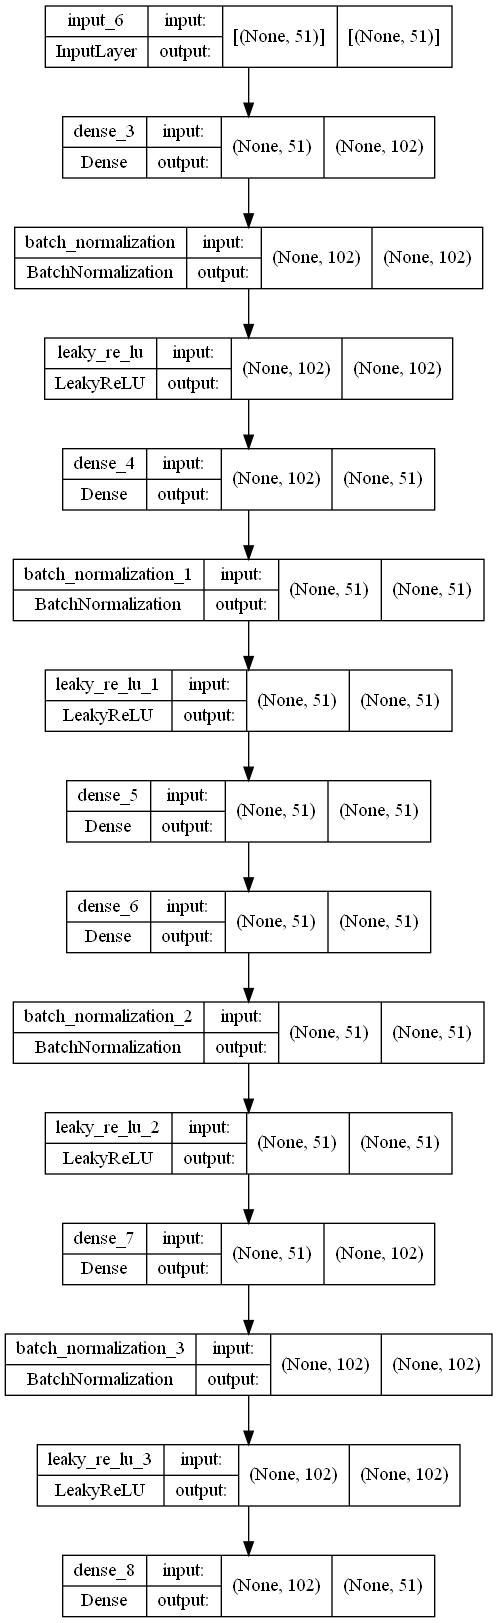

<IPython.core.display.Javascript object>

In [53]:
## We can plot the layers in the autoencoder model to get a feeling for how the data flows through the model.

# plot the autoencoder
from tensorflow.keras.utils import plot_model

plot_model(model, "autoencoder_no_compress.png", show_shapes=True)

In [55]:
# fit the autoencoder model to reconstruct input
history = model.fit(
    X_seq,
    X_seq2,
    epochs=200,
    batch_size=16,
    verbose=0,
    validation_data=(X_seq, X_seq2),
)

ValueError: in user code:

    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1021, in train_function  *
        return step_function(self, iterator)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1010, in step_function  **
        outputs = model.distribute_strategy.run(run_step, args=(data,))
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 1000, in run_step  **
        outputs = model.train_step(data)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\training.py", line 859, in train_step
        y_pred = self(x, training=True)
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\utils\traceback_utils.py", line 67, in error_handler
        raise e.with_traceback(filtered_tb) from None
    File "c:\users\psraj\appdata\local\programs\python\python38\lib\site-packages\keras\engine\input_spec.py", line 264, in assert_input_compatibility
        raise ValueError(f'Input {input_index} of layer "{layer_name}" is '

    ValueError: Input 0 of layer "model_3" is incompatible with the layer: expected shape=(None, 51), found shape=(16, 25, 4)


<IPython.core.display.Javascript object>